In [1]:
import mne

In [2]:
import pandas as pd

In [3]:
import json

In [4]:
# %matplotlib inline
import matplotlib.pyplot as plt

In [5]:
import numpy as np

In [6]:
import matplotlib

In [7]:
%load_ext autoreload

%autoreload 2
import tools

In [8]:
import datetime as dt

In [9]:
import eeg_events

# Чтение сигнала и событий

In [10]:
ch_names = ["Fp1", "Fp2", "C3", "C4", "P7", "P8", 'O1', 'O2']

In [11]:
sampling_freq = 256
n_channels = len(ch_names)
ch_types = ["eeg"] * n_channels

In [12]:
events_name = f"./valid-data/subject-sasha/events/casino-bci-sasha-6.json"

In [13]:
baseline_name = f"./valid-data/subject-sasha/eeg/sasha6.txt"

In [14]:
events_df = tools.read_events_df(events_name, lambda x: True)

In [15]:
baseline_raw = tools.read_signal(
    baseline_name, 
    ch_names=ch_names, 
    ch_types=ch_types, 
    sampling_freq=sampling_freq
)

/home/anatoli/Документы/skywind/eeg-playground/tools.py:17: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  sep=", ", skiprows=6, names=["#"] + ch_names + ["x", "y", "z", "time", "timestamp"]


Creating RawArray with float64 data, n_channels=8, n_times=108904
    Range : 0 ... 108903 =      0.000 ...   425.402 secs
Ready.
Setting up band-stop filter from 48 - 52 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 48.00
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 47.75 Hz)
- Upper passband edge: 52.00 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 52.25 Hz)
- Filter length: 1691 samples (6.605 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lo

# Фильтрация

In [18]:
# # time_stats = (75, 30)
# time_stats = (
#     15, 
#     400
# )

# raw_part = baseline_raw.copy() \
#     .crop(tmin=time_stats[0], tmax=time_stats[1])


# tools.plot_frequencies(raw_part, frequencies=(1, 50), start=0, duration=20)

# ica = mne.preprocessing.ICA()

# ica.fit(raw_part.copy())

# ica_eeg = ica.get_sources(raw_part)

# _ = mne.viz.plot_raw(
#     ica_eeg,
#     duration=30, 
#     start=0, 
#     scalings=5,
#     show=True
# )

# transformed_raw = ica.apply(raw_part.copy(), exclude=[0, 5]).pick(["Fp1", "Fp2", "O1", "O2"])

# tools.plot_frequencies(transformed_raw, frequencies=(1, 50), start=0, duration=20)

In [21]:
transformed_raw = baseline_raw

# Сохранение

In [22]:
raw_alpha = tools.get_alpha_amplitude(transformed_raw, sampling_freq=sampling_freq, channels=["O1", "O2"])#.crop(tmin=time_stats[0], tmax=time_stats[1])

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 423 samples (1.652 sec)

Creating RawArray with float64 data, n_channels=5, n_times=108904
    Range : 0 ... 108903 =      0.000 ...   425.402 secs
Ready.


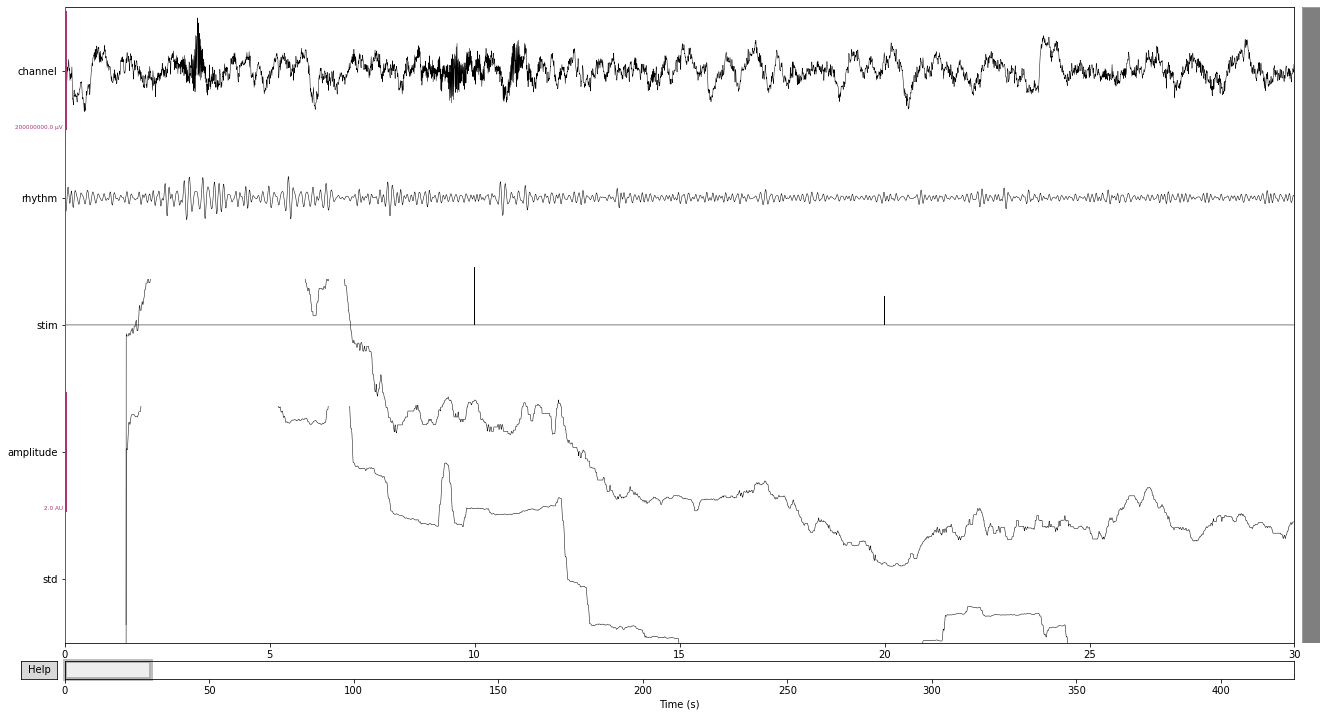

In [23]:
_ = mne.viz.plot_raw(
    raw_alpha,
    duration=30, 
    start=0, 
    scalings={
        "eeg": 100,
        "misc": 1
    },
    show=True
)

In [24]:
eeg_events.save_events(raw_alpha, events_df, 'test-filtered')

Writing /home/anatoli/Документы/skywind/eeg-playground/valid-data/processed/test-filtered.raw.fif
Closing /home/anatoli/Документы/skywind/eeg-playground/valid-data/processed/test-filtered.raw.fif [done]
